In [2]:
import numpy as np
import capytaine as cpt
import xarray as xr
from scipy.linalg import eig
from math import pi

mesh_file = "2112open.stl"
user_defined_cog = None

g = 9.81
rho = 1000.0

K_mooring = np.zeros((6, 6))
spring_k = 119
K_mooring[0, 0] = 2 * spring_k

print("--- Starting Eigenvalue Analysis for Free Oscillations ---")

print(f"\n1. Loading mesh: {mesh_file}")
boat_mesh = cpt.load_mesh(mesh_file, file_format="stl")

if user_defined_cog is None:
    print("   User-defined CoG not provided. Attempting to use boat_mesh.center_of_buoyancy.")
    try:
        cob_value = boat_mesh.center_of_buoyancy 
        if cob_value is None: 
             raise ValueError("boat_mesh.center_of_buoyancy is None.")
        cog = np.array(cob_value, dtype=float)
        print(f"   Using boat_mesh.center_of_buoyancy as CoG: {cog} (type: {type(cog)})")
    except AttributeError:
        print(f"   CRITICAL ERROR: boat_mesh.center_of_buoyancy attribute does not exist.")
        print("   The mesh object does not have 'center_of_buoyancy'.")
        print("   Please provide a user_defined_cog or ensure the mesh provides this attribute.")
        print("   Exiting.")
        exit()
    except ValueError as e:
        print(f"   CRITICAL ERROR: {e}")
        print("   Exiting.")
        exit()
    except Exception as e:
        print(f"   CRITICAL ERROR: Could not obtain center of buoyancy from boat_mesh: {e}")
        print("   Exiting.")
        exit()
else:
    cog = np.array(user_defined_cog)
    print(f"   Using user-defined CoG: {cog}")

print("\n2. Building FloatingBody object...")
omega_max_lid = 4 * pi 
z0_lid = boat_mesh.lowest_lid_position(omega_max=omega_max_lid)
h_min_original_hull = boat_mesh.vertices[:,2].min() 

print(f"   Calculated lid_z for original boat_mesh using lowest_lid_position = {z0_lid:.4f} (h_min_original_hull = {h_min_original_hull:.4f})")
print(f"   Using this z0_lid directly for generate_lid.")

lid_mesh = boat_mesh.generate_lid(z=z0_lid) 
print(f"   Lid mesh for original boat_mesh: {lid_mesh.nb_vertices} verts, {lid_mesh.nb_faces} faces")

if lid_mesh.nb_vertices == 0 or lid_mesh.nb_faces == 0:
    print("   CRITICAL WARNING: Generated lid_mesh (for original boat_mesh) has 0 vertices or 0 faces.")
    print("   This indicates generate_lid() failed to create a valid lid.")

body = cpt.FloatingBody(
    mesh=boat_mesh,
    lid_mesh=lid_mesh,
    dofs=cpt.rigid_body_dofs(rotation_center=cog), 
    center_of_mass=cog, 
    name="ship_eigen_analysis"
)
dof_names = list(body.dofs.keys())
print(f"   FloatingBody '{body.name}' created with DoFs: {dof_names}")

print("\n3. Computing mass properties and hydrostatic stiffness...")

try:
    hydrostatics_results = body.compute_hydrostatics(rho=rho, g=g)
    
    body.hydrostatic_stiffness = hydrostatics_results["hydrostatic_stiffness"]
    C_for_eig = body.hydrostatic_stiffness.data 
    print("   Hydrostatic stiffness matrix (C) computed and assigned to body.hydrostatic_stiffness.")

    actual_cog_used = body.center_of_mass.data if hasattr(body.center_of_mass, 'data') else body.center_of_mass
    calculated_cob = hydrostatics_results["center_of_buoyancy"].data
    print(f"   VERIFICATION: CoG used for FloatingBody definition: {actual_cog_used}")
    print(f"   VERIFICATION: CoB calculated from hydrostatics_results: {calculated_cob}")
    if actual_cog_used is not None and calculated_cob is not None:
        print(f"   VERIFICATION: Z_CoG = {actual_cog_used[2]:.4f}, Z_CoB = {calculated_cob[2]:.4f}")
        if actual_cog_used[2] < calculated_cob[2]:
            print("   VERIFICATION: Note - CoG is below CoB. This might indicate potential instability depending on metacentric height.")
        else:
            print("   VERIFICATION: Note - CoG is at or above CoB.")
    # --- End Verification ---

    immersed_volume = hydrostatics_results["disp_volume"].item() 
    print(f"   Immersed volume (from hydrostatics_results['disp_volume']): {immersed_volume:.4f} m^3")
    if immersed_volume <= 1e-9:
        raise ValueError("Immersed volume is zero or negligible. This will lead to zero mass.")
    body.mass = immersed_volume * rho 
    print(f"   body.mass attribute set to: {body.mass:.2f} kg")

except Exception as e:
    print(f"   CRITICAL ERROR during hydrostatic calculations or mass assignment: {e}")
    print("   This often indicates issues with mesh closure or lid placement. Exiting.")
    exit()

try:
    M_body_xarray = body.compute_rigid_body_inertia()
    
    if np.any(np.isnan(M_body_xarray.data)) or np.any(np.isinf(M_body_xarray.data)):
        print("   CRITICAL ERROR: body.compute_rigid_body_inertia() resulted in NaN or Inf values.")
        print("   This is likely due to the mesh not being properly closed ('Boundary is not closed !!!' warning).")
        print("   Calculated 6x6 inertia matrix (M_body_xarray.data):\n", M_body_xarray.data)
        print("   The script cannot proceed with invalid inertia values. Exiting.")
        exit()
        
    body.inertia_matrix = M_body_xarray 
    M_body_for_eig = body.inertia_matrix.data 
    
    print(f"   body.inertia_matrix (6x6) attribute successfully set.")

except Exception as e:
    print(f"   CRITICAL ERROR computing or assigning body.inertia_matrix (6x6): {e}")
    print("   This can happen if body.mass was not properly set or if volumetric integrals failed (e.g., due to an open mesh).")
    print("   The script cannot proceed without a valid 6x6 inertia matrix. Exiting.")
    exit()

print("\n4. Computing added mass matrix at (near) zero frequency A(0)...")
omega_for_A0 = 1e-5  

radiation_problems_A0 = []
for dof_name in dof_names:
    problem = cpt.RadiationProblem(
        body=body,
        radiating_dof=dof_name,
        omega=omega_for_A0,
        rho=rho,
        g=g,
        water_depth=np.inf  
    )
    radiation_problems_A0.append(problem)

solver = cpt.BEMSolver()
try:
    print(f"   Solving {len(radiation_problems_A0)} radiation problems for A(0) at omega = {omega_for_A0:.1e} rad/s...")
    radiation_results_A0 = solver.solve_all(radiation_problems_A0)
    print("   Radiation problems for A(0) solved.")
except Exception as e:
    print(f"   CRITICAL ERROR during solution of radiation problems for A(0): {e}")
    print("   Exiting.")
    exit()

try:
    dataset_A0 = cpt.assemble_dataset(radiation_results_A0)
    A_at_zero_freq_xarray = dataset_A0["added_mass"].sel(omega=omega_for_A0, drop=True)
    A_at_zero_freq = A_at_zero_freq_xarray.data
    
    if np.any(np.isnan(A_at_zero_freq)) or np.any(np.isinf(A_at_zero_freq)):
        print("   CRITICAL ERROR: Added mass matrix A(0) contains NaN or Inf values.")
        print("   Calculated A(0) matrix:\n", A_at_zero_freq)
        print("   This could be due to mesh issues or solver problems at very low frequencies. Exiting.")
        exit()
        
    print("   Added mass matrix A(0) computed successfully.")
    # print("   A(0) (Added Mass at omega_for_A0):\n", A_at_zero_freq)

except Exception as e:
    print(f"   CRITICAL ERROR extracting or processing added mass matrix A(0): {e}")
    print("   Exiting.")
    exit()

print("\n5. Solving the generalized eigenvalue problem...")


if 'K_mooring' not in locals():
    K_mooring = np.zeros_like(C_for_eig) 
    print("   INFO: Mooring stiffness matrix K_mooring not found, using zeros.")



LHS_matrix = C_for_eig + K_mooring
RHS_matrix = M_body_for_eig + A_at_zero_freq  

try:
    print("   LHS matrix (K = Hydrostatic Stiffness):\n", LHS_matrix)
    print("   RHS matrix (M_total = Body Inertia + A(0)):\n", RHS_matrix)
    
    if np.linalg.cond(RHS_matrix) > 1e12: 
        print("   WARNING: The RHS matrix (M_total) is ill-conditioned. Results might be inaccurate.")
        print(f"   Condition number of M_total: {np.linalg.cond(RHS_matrix):.2e}")

    eigenvalues_sq_omega, eigenvectors = eig(LHS_matrix, RHS_matrix)
    print("   Eigenvalue problem solved.")

except np.linalg.LinAlgError as e:
    print(f"   CRITICAL ERROR: Linear algebra error during eigenvalue solution: {e}")
    print("   This might be due to singular matrices. Check K and (M+A(0)).")
    print("   Exiting.")
    exit()
except Exception as e:
    print(f"   CRITICAL ERROR during eigenvalue solution: {e}")
    print("   Exiting.")
    exit()

print("\n6. Eigenvalue Analysis Results:")

results = []
for i in range(len(eigenvalues_sq_omega)):
    lambda_val = eigenvalues_sq_omega[i]
    eigenvector = eigenvectors[:, i]

    omega_sq = np.real(lambda_val) 
    
    if np.abs(np.imag(lambda_val)) > 1e-6 * np.abs(np.real(lambda_val)) and np.abs(np.imag(lambda_val)) > 1e-9 :
        print(f"   Warning: Eigenvalue {i+1} has a significant imaginary part: {lambda_val}. This might indicate numerical issues or damped modes not captured by this model.")

    if omega_sq < -1e-9:
        omega = np.sqrt(-omega_sq) 
        period = np.nan 
        stability_info = f"Unstable mode (ω^2 = {omega_sq:.4e}, ω_imag = {omega:.4e} rad/s)"
    elif omega_sq < 1e-9:
        omega = 0.0
        period = np.inf
        stability_info = f"Zero-frequency mode (ω^2 = {omega_sq:.4e}, ω = {omega:.4e} rad/s)"
    else:
        omega = np.sqrt(omega_sq)
        period = 2 * pi / omega if omega > 1e-9 else np.inf
        stability_info = f"Stable mode (ω = {omega:.4f} rad/s, T = {period:.4f} s)"
        
    results.append({
        "id": i + 1,
        "omega_sq": omega_sq,
        "omega": omega,
        "period": period,
        "eigenvector": eigenvector / np.linalg.norm(eigenvector),
        "stability_info": stability_info
    })

results.sort(key=lambda r: (r["omega_sq"] < -1e-9, abs(r["omega_sq"])))


print("\n--- Natural Frequencies, Periods, and Mode Shapes ---")
print(f"   Degrees of Freedom: {dof_names}")
for res in results:
    print(f"\nMode {res['id']}:")
    print(f"   {res['stability_info']}")
    if not (res['omega_sq'] < -1e-9):
         print(f"   Natural Frequency (ω): {res['omega']:.4f} rad/s")
         print(f"   Natural Period (T): {res['period']:.4f} s")
    print(f"   Eigenvalue (ω^2): {res['omega_sq']:.4e}")
    print(f"   Normalized Eigenvector (Mode Shape):")
    for j, component in enumerate(res['eigenvector']):
        if isinstance(component, complex):
            print(f"     {dof_names[j]:<10}: {np.real(component):.4f} + {np.imag(component):.4f}j")
        else:
            print(f"     {dof_names[j]:<10}: {component:.4f}")

print("\n--- Eigenvalue Analysis Complete ---")




--- Starting Eigenvalue Analysis for Free Oscillations ---

1. Loading mesh: 2112open.stl
   User-defined CoG not provided. Attempting to use boat_mesh.center_of_buoyancy.
   Using boat_mesh.center_of_buoyancy as CoG: [ 0.00287967 -0.00050748 -0.01680548] (type: <class 'numpy.ndarray'>)

2. Building FloatingBody object...
   Calculated lid_z for original boat_mesh using lowest_lid_position = -0.0720 (h_min_original_hull = -0.1072)
   Using this z0_lid directly for generate_lid.
   Lid mesh for original boat_mesh: 742 verts, 655 faces
Boundary is not closed !!!
Boundary is not closed !!!
Boundary is not closed !!!
   FloatingBody 'ship_eigen_analysis' created with DoFs: ['Surge', 'Sway', 'Heave', 'Roll', 'Pitch', 'Yaw']

3. Computing mass properties and hydrostatic stiffness...
   Hydrostatic stiffness matrix (C) computed and assigned to body.hydrostatic_stiffness.
   VERIFICATION: CoG used for FloatingBody definition: <memory at 0x000001F15E846440>
   VERIFICATION: CoB calculated from 

[13:18:40] WARNING  The mesh of the body FloatingBody(..., name="ship_eigen_analysis") has 2835 panels above the   
                    free surface.                                                                                  
                    It has been clipped to fit inside the domain.                                                  
                    To remove this warning, clip the mesh manually with the `immersed_part()` method.

           WARNING  The mesh of the body FloatingBody(..., name="ship_eigen_analysis") has 2835 panels above the   
                    free surface.                                                                                  
                    It has been clipped to fit inside the domain.                                                  
                    To remove this warning, clip the mesh manually with the `immersed_part()` method.

[13:18:41] WARNING  The mesh of the body FloatingBody(..., name="ship_eigen_analysis") has 2835 panels above the   
                    free surface.                                                                                  
                    It has been clipped to fit inside the domain.                                                  
                    To remove this warning, clip the mesh manually with the `immersed_part()` method.

           WARNING  The mesh of the body FloatingBody(..., name="ship_eigen_analysis") has 2835 panels above the   
                    free surface.                                                                                  
                    It has been clipped to fit inside the domain.                                                  
                    To remove this warning, clip the mesh manually with the `immersed_part()` method.

           WARNING  The mesh of the body FloatingBody(..., name="ship_eigen_analysis") has 2835 panels above the   
                    free surface.                                                                                  
                    It has been clipped to fit inside the domain.                                                  
                    To remove this warning, clip the mesh manually with the `immersed_part()` method.

           WARNING  The mesh of the body FloatingBody(..., name="ship_eigen_analysis") has 2835 panels above the   
                    free surface.                                                                                  
                    It has been clipped to fit inside the domain.                                                  
                    To remove this warning, clip the mesh manually with the `immersed_part()` method.

   Solving 6 radiation problems for A(0) at omega = 1.0e-05 rad/s...


Output()

   Radiation problems for A(0) solved.
   Added mass matrix A(0) computed successfully.

5. Solving the generalized eigenvalue problem...
   LHS matrix (K = Hydrostatic Stiffness):
 [[ 2.38000000e+02  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  2.14463110e+03  4.68160350e-02
   3.40646547e+01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  4.68160350e-02  7.10040332e+00
   5.20458906e+00 -3.11892586e+00]
 [ 0.00000000e+00  0.00000000e+00  3.40646547e+01  5.20458906e+00
   1.37070105e+02  1.18852688e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
   RHS matrix (M_total = Body Inertia + A(0)):
 [[ 1.53046956e+01  3.89669414e-01  6.13026624e-01  2.40590686e-02
   1.00361904e+00  2.02751131e-02]
 [ 3.92946080e-01  2.50313575e+01  1.09181695e-01 -4.41721051e

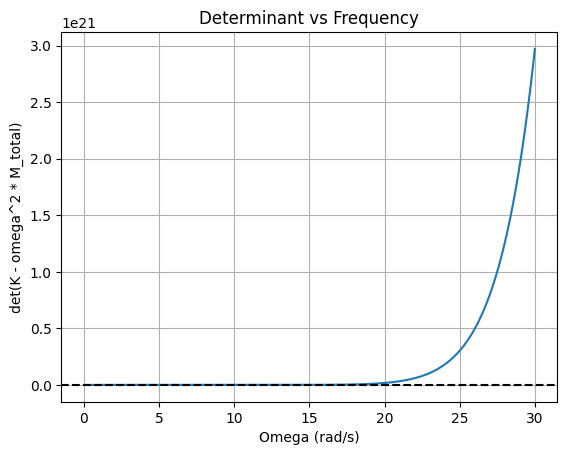

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Sweep omega range and compute determinant of (K - omega^2 M_total)
omegas = np.linspace(0, 30, 5000)
dets = [np.linalg.det(LHS_matrix - omega**2 * RHS_matrix) for omega in omegas]


plt.figure()
plt.plot(omegas, dets)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Omega (rad/s)')
plt.ylabel('det(K - omega^2 * M_total)')
plt.title('Determinant vs Frequency')
plt.grid(True)
plt.show()